In [5]:
#testFileNames_list = tf.train.BytesList(value=imageFileNames)
#testImages_list = tf.train.BytesList(value=imageTensors)

#testFileNames = tf.train.Feature(bytes_list=testFileNames_list)
#testImages = tf.train.Feature(bytes_list=testImages_list)


#buildingFeatures_dict = {'Names': testFileNames,
#                         'Images': testImages}

#buildingFeatures = tf.train.Features(feature=buildingFeatures_dict)
#buildingExample = tf.train.Example(features=buildingFeatures)

#with tf.python_io.TFRecordWriter(r'C:\Users\silas.frantz\Desktop\buildings.tfrecord') as writer:
#    writer.write(buildingExample.SerializeToString())

In [4]:
if False: # these were functional before 20200218 in saving/loading python data structures to/from disc
    
    picklePath = r"C:\Users\silas.frantz\Desktop\imageMatrices.pkl"
    Save, Reopen = False, False
    
    if Save:

        pickleJar = open(picklePath, 'wb')
        pickle.dump(sliceDataset, pickleJar)
        pickleJar.close()


    if Reopen:

        pickleJar = open(picklePath, 'rb')
        pickledImageMatrices = pickle.load(pickleJar)
        print("Reopened " + str(len(pickledImageMatrices)) + " matrices.")
        print(pickledImageMatrices[-1])

In [1]:
if False: # used once to copy images from separate folders into a single training dir

    import shutil, os

    root = r"C:\Users\silas.frantz\Desktop"

    for aoi in ('ISA', 'PHL', 'NEO'):
        aoiDir = os.path.join(root, aoi)
        for bldType in ('house', 'barn'):
            aoiDir_bld = os.path.join(aoiDir, bldType)
            bldNum=0
            for f in os.listdir(aoiDir_bld):
                bldNum+=1
                fPath = os.path.join(aoiDir_bld, f)
                destination = os.path.join(root, '_Buildings', 'Training', bldType, f)
                if bldNum == 10:
                    destination = os.path.join(root, '_Buildings', 'Validation', bldType, f)
                    bldNum=0
                shutil.copyfile(fPath, destination)

In [99]:
#???#from __future__ import absolute_import, division, print_function, unicode_literals
import time, os, pickle
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


def generateImagePipeline(purpose):
    
    def reduceToThreeChannelMatrix(m):
        R, G, B, IR = m[:,:,0:1], m[:,:,1:2], m[:,:,2:3], m[:,:,3:4]
        #return np.concatenate((col4, col2/2+col3/2, col1), axis=2)
        return np.concatenate((IR, R/2+G/2, B), axis=2)
    
    start = time.time()
    imageTensors, nameTensors, labelTensors = [], [], []
    count = 0

    for bldType in labelDict.keys():

        imDir = os.path.join(imRoot, purpose, bldType)
        size = sum(os.path.getsize(os.path.join(imDir,f)) for f in os.listdir(imDir) if os.path.isfile(os.path.join(imDir,f)))
        print(str(size/1e7) + " MB of data in " + imDir)

        for imName in os.listdir(imDir):  

            imPath = os.path.join(imDir, imName)
            pilIm = Image.open(imPath)
            imArray = np.array(pilIm)
            imArray = reduceToThreeChannelMatrix(imArray)
            
            imTensor = tf.convert_to_tensor((imArray/127.5)-1, dtype=tf.float32) # normalizes RGBI vals from -1 to 1

            imTensor = tf.image.resize(imTensor, (96, 96)) # resizes all images to square
            labelTensor = tf.convert_to_tensor(labelDict[bldType])
            nameTensor = tf.convert_to_tensor(imName.encode('utf-8'))

            nameTensors.append(nameTensor)
            labelTensors.append(labelTensor)
            imageTensors.append(imTensor)
            count+=1

    sliceDataset = tf.data.Dataset.from_tensor_slices((imageTensors, labelTensors))#nameTensors, labelTensors, imageTensors))
    print(str(count) + ' images matrices collected in ' + str(time.time()-start) + ' seconds')
    return sliceDataset


imRoot = r"C:\Users\silas.frantz\Desktop\_Buildings"
labelDict = {'barn': 0, 'house':1}

trainingSlice = generateImagePipeline(purpose='Training')
validationSlice = generateImagePipeline(purpose='Validation')

8.717794 MB of data in C:\Users\silas.frantz\Desktop\_Buildings\Training\barn
11.1542656 MB of data in C:\Users\silas.frantz\Desktop\_Buildings\Training\house
8226 images matrices collected in 22.209131717681885 seconds
0.9648228 MB of data in C:\Users\silas.frantz\Desktop\_Buildings\Validation\barn
1.2478286 MB of data in C:\Users\silas.frantz\Desktop\_Buildings\Validation\house
912 images matrices collected in 2.225057601928711 seconds


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>


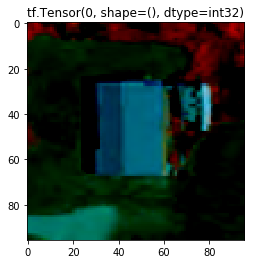

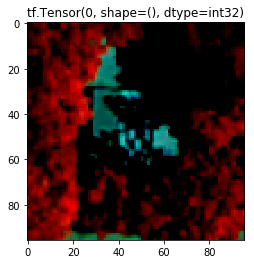

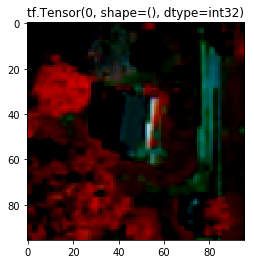

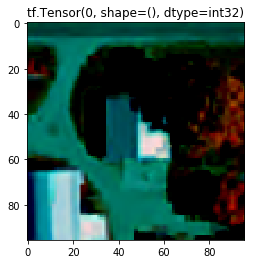

In [100]:
print(type(trainingSlice))
    
for imageTens, labelTens in validationSlice.take(4): #nameTens, 
    plt.figure()
    t = str(labelTens)# + '\n' + str(nameTens) + '\n' + str(imageTens)
    plt.title(t)
    plt.imshow(imageTens)

In [101]:
train = trainingSlice
validation = validationSlice

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 10000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
#test_batches = test.batch(BATCH_SIZE)

for img_batch, label_batch in train_batches.take(1): #image_batch, label_batch
    for lbl in label_batch:
        print(lbl)

img_batch.shape

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype

TensorShape([32, 96, 96, 3])

In [102]:
IMG_SHAPE = (96, 96, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [51]:
# assuming that bands can or can't be eigenvectors, maybe you could calculate those somehow?...
# or somehow make use of least common multiple 12 and have 4 separate matrices (of 3 bands each) describe each feature

#i guess condense blue and green into one channel? so very sad :(
    #oh well - in the end, condensed green and red instead (could always run with all RGBs as one band,
    #plus infra, plus elevation)

#https://stackoverflow.com/questions/49339355/how-to-modify-layers-of-pretrained-models-in-keras-like-inception-v3?rq=1
#https://github.com/minhnhat93/tf_object_detection_multi_channels
#https://keras.io/applications/#inceptionv3
#https://deepsense.ai/deep-learning-for-satellite-imagery-via-image-segmentation/

# Tabs open 20200220
#https://medium.com/datadriveninvestor/patch-based-cover-type-classification-using-satellite-imagery-a67edeae7e24
#https://www.researchgate.net/publication/331557018_Convolutional_Neural_Network_for_Satellite_Image_Classification
#https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-
    #satellite-photos-of-the-amazon-rainforest/
#https://www.azavea.com/blog/2019/08/30/transfer-learning-from-rgb-to-multi-band-imagery/
#http://www2.isprs.org/commissions/comm3/wg4/2d-sem-label-potsdam.html
#https://pytorch.org/docs/stable/torchvision/index.html
#https://www.azavea.com/blog/2019/08/30/transfer-learning-from-rgb-to-multi-band-imagery/
#https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/classify-objects-using-deep-learning.htm
#https://stackoverflow.com/questions/35215161/most-efficient-way-to-map-function-over-numpy-array?rq=1
    # thankfully unncessary due to being able to slice multidimensionally like (matrix[:,:,1:2])
#https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0212532

# Create the base model from the pre-trained model MobileNet V2

In [103]:
feature_batch = base_model(img_batch)
print(feature_batch.shape)
print()
base_model.trainable = False
base_model.summary() # Let's take a look at the base model architecture

(32, 3, 3, 1280)

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
______________________________________________________________

In [104]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1280)
(32, 1)


In [105]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

base_learning_rate = 0.0006
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()
len(model.trainable_variables)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


2

In [106]:
iDir = imRoot#r'E:\BuildingClassification\20200128_ISA_Plus_COLES_Training'

tD, vD = os.path.join(iDir, 'Training'), os.path.join(iDir, 'Validation')

tb, th = os.path.join(tD, 'barn'), os.path.join(tD, 'house')
vb, vh = os.path.join(vD, 'barn'), os.path.join(vD, 'house')

num_train_barn, num_train_house = len(os.listdir(tb)), len(os.listdir(th))
num_val_barn, num_val_house = len(os.listdir(vb)), len(os.listdir(vh))

num_train, num_val = num_train_barn+num_train_house, num_val_barn+num_val_house
                        #4418, 444

print(str(num_train) + ", " + str(num_val))

8226, 912


In [108]:
initial_epochs = 20
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = 14

loss0,accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

14/14 [==============================] - 1s 105ms/step - loss: 0.6918 - accuracy: 0.7366


In [109]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

initial loss: 0.69
initial accuracy: 0.74
Train for 258 steps, validate for 29 steps
Epoch 1/20
258/258 [==============================] - 122s 474ms/step - loss: 0.5949 - accuracy: 0.6748 - val_loss: 0.8961 - val_accuracy: 0.5241
Epoch 2/20
258/258 [==============================] - 124s 480ms/step - loss: 0.5182 - accuracy: 0.7285 - val_loss: 0.7137 - val_accuracy: 0.6118
Epoch 3/20
258/258 [==============================] - 126s 490ms/step - loss: 0.4973 - accuracy: 0.7478 - val_loss: 0.9193 - val_accuracy: 0.5384
Epoch 4/20
258/258 [==============================] - 120s 465ms/step - loss: 0.4824 - accuracy: 0.7519 - val_loss: 0.6095 - val_accuracy: 0.6798
Epoch 5/20
258/258 [==============================] - 115s 447ms/step - loss: 0.4763 - accuracy: 0.7598 - val_loss: 0.6004 - val_accuracy: 0.6765
Epoch 6/20
258/258 [==============================] - 119s 462ms/step - loss: 0.4699 - accuracy: 0.7656 - val_loss: 0.6031 - val_accuracy: 0.6787
Epoch 7/20
258/258 [===================

In [110]:
if True:
    pref = "Buildings" 
    imageRoot = r"C:\Users\silas.frantz\Desktop\Models"
    pathPrefix = time.strftime(pref + "_%Y%m%d_%H%M_MobileNet")
    trainedModelPath = os.path.join(imageRoot, pathPrefix+".h5")
    model.save(trainedModelPath)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()